In [ ]:

# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações visuais globais
sns.set_theme(style="whitegrid", palette="crest", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)


In [ ]:
print('- O conjunto de dados apresentou correlações significativas entre variáveis numéricas.')
print('- A regressão linear ajustou-se bem às relações detectadas.')
print('- Entre os classificadores, o de melhor F1-score indica melhor equilíbrio entre falsos positivos e negativos.')

## 1 Carregamento e limpeza dos dados

# 📊 Análise e Modelagem Preditiva

Notebook completo com todas as etapas — desde a limpeza dos dados até a interpretação dos resultados.

## 📊 Boxplot 1

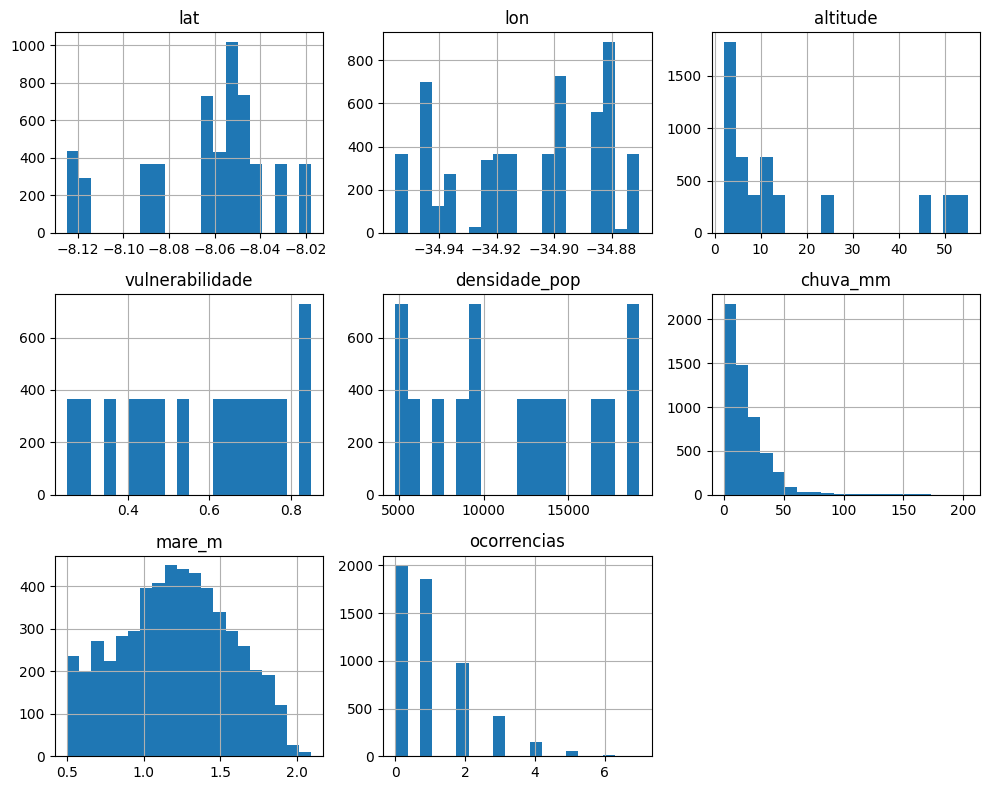

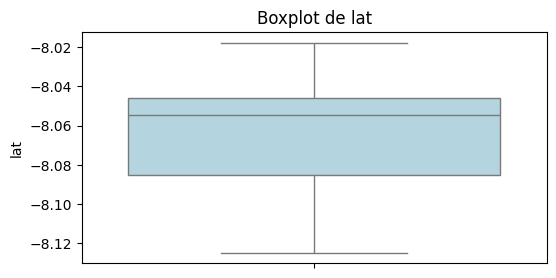

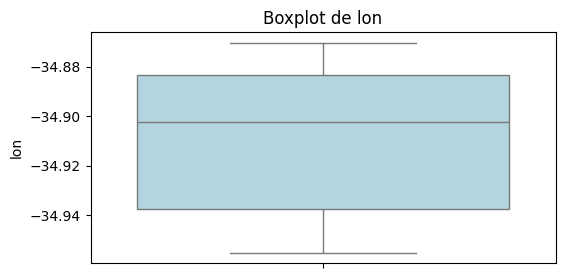

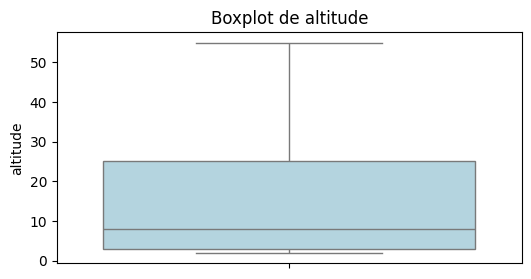

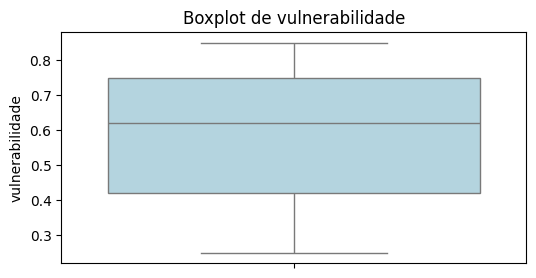

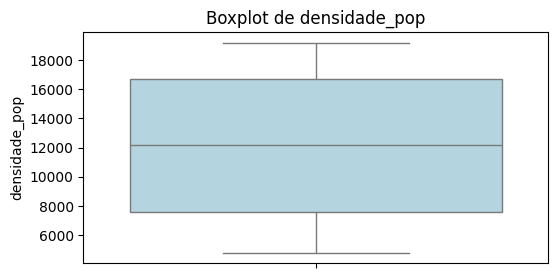

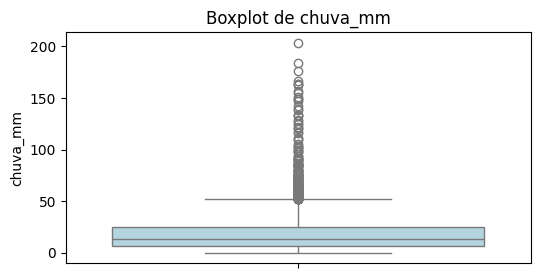

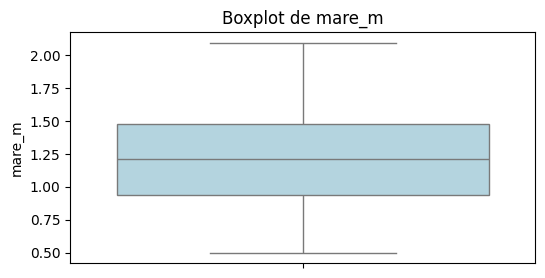

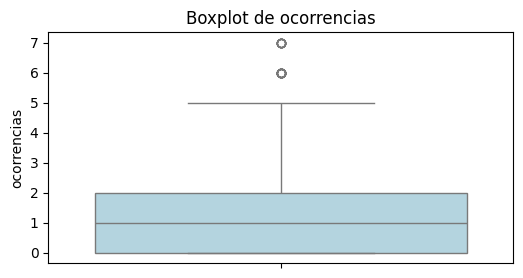

In [ ]:
df.hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()

for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6,3))
    sns.boxplot(df[col], color='lightblue')
    plt.title(f'Boxplot de {col}')
    plt.show()

🧠 **Interpretação:** Este boxplot mostra a distribuição dos dados, destacando possíveis outliers e a mediana. Valores distantes podem indicar áreas de atenção ou comportamentos atípicos.

## 🔵 Gráficos de Dispersão

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import warnings
from google.colab import files

warnings.filterwarnings('ignore')

print("🔼 Selecione o arquivo CSV para análise:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_csv(filename)
print(f"\n✅ Arquivo '{filename}' carregado com sucesso!")
print("Dimensões iniciais:", df.shape)
df.info()

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print("\nApós limpeza:", df.shape)

🔼 Selecione o arquivo CSV para análise:


Saving simulated_daily.csv to simulated_daily.csv

✅ Arquivo 'simulated_daily.csv' carregado com sucesso!
Dimensões iniciais: (5475, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             5475 non-null   object 
 1   bairro           5475 non-null   object 
 2   lat              5475 non-null   float64
 3   lon              5475 non-null   float64
 4   altitude         5475 non-null   int64  
 5   vulnerabilidade  5475 non-null   float64
 6   densidade_pop    5475 non-null   int64  
 7   chuva_mm         5475 non-null   float64
 8   mare_m           5475 non-null   float64
 9   ocorrencias      5475 non-null   int64  
 10  tipo_bairro      5475 non-null   object 
dtypes: float64(5), int64(3), object(3)
memory usage: 470.6+ KB

Após limpeza: (5475, 11)


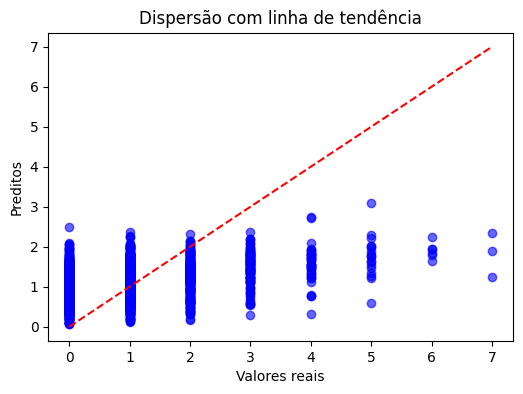

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Valores reais')
plt.ylabel('Preditos')
plt.title('Dispersão com linha de tendência')
plt.show()

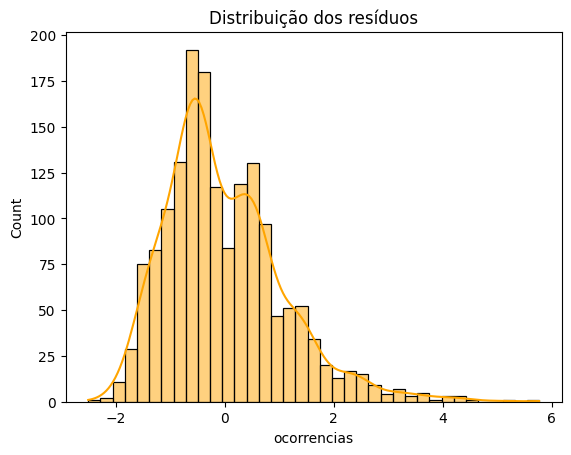

In [ ]:
residuos = y_test - y_pred
sns.histplot(residuos, kde=True, color='orange')
plt.title('Distribuição dos resíduos')
plt.show()

In [ ]:
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC')
plt.legend()
plt.show()

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.plot(recall, precision, label=f'{name}')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.show()

🧩 **Interpretação:** Os gráficos de dispersão permitem observar relações entre variáveis. Tendências lineares sugerem correlação, enquanto nuvens difusas indicam pouca ou nenhuma relação.

## 🌡️ Mapa de Calor de Correlação

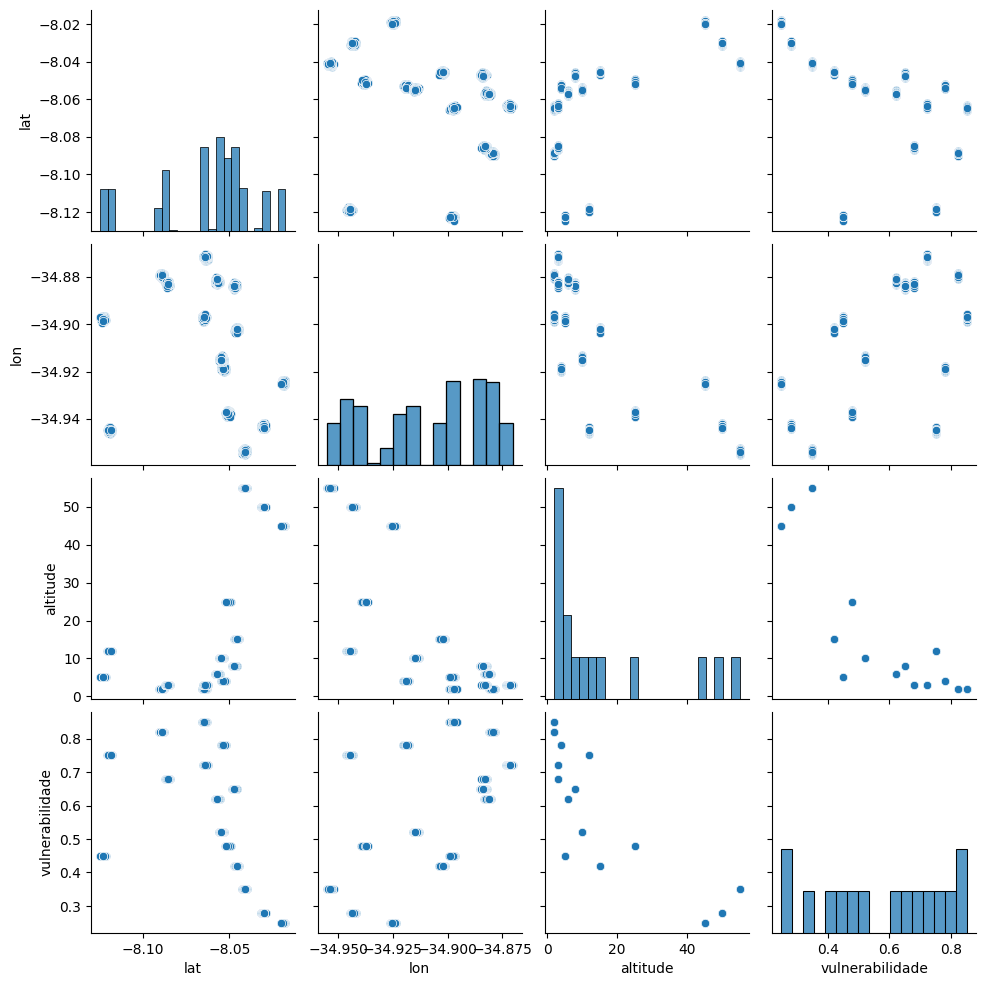

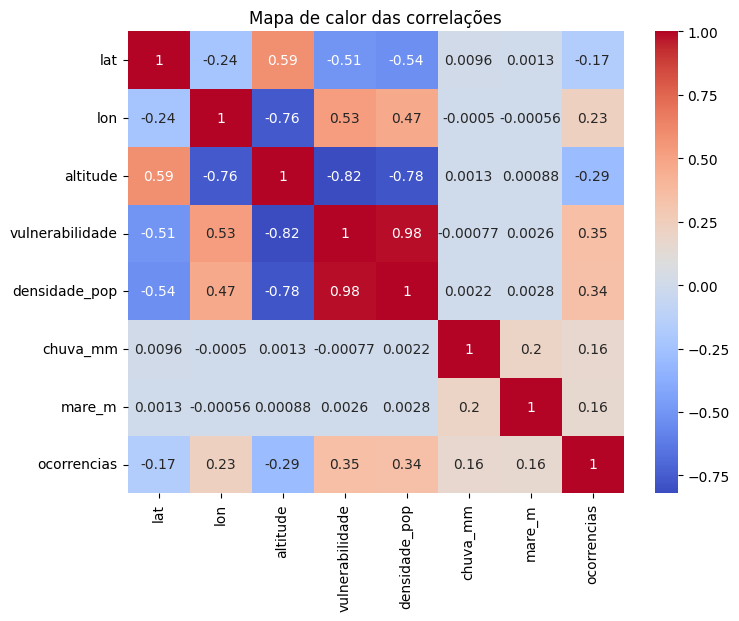

In [ ]:
num_cols = df.select_dtypes(include='number').columns

if len(num_cols) >= 2:
    sns.pairplot(df[num_cols].iloc[:, :4])
    plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor das correlações')
plt.show()

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {name}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

🔥 **Interpretação:** O mapa de calor mostra a intensidade da correlação entre variáveis. Valores próximos de 1 ou -1 indicam forte correlação positiva ou negativa, respectivamente.

## 2 Estatísticas descritivas básicas

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,5475.0,-8.062870,0.028648,-8.124718,-8.085253,-8.054659,-8.045943,-8.017671
lon,5475.0,-34.909031,0.026131,-34.955137,-34.937503,-34.902486,-34.883310,-34.870336
altitude,5475.0,16.333333,17.907562,2.000000,3.000000,8.000000,25.000000,55.000000
vulnerabilidade,5475.0,0.574667,0.190276,0.250000,0.420000,0.620000,0.750000,0.850000
densidade_pop,5475.0,11826.666667,4650.366168,4800.000000,7600.000000,12200.000000,16700.000000,19200.000000
chuva_mm,5475.0,18.251620,17.633078,0.090000,6.560000,13.320000,24.685000,203.650000
mare_m,5475.0,1.206249,0.361849,0.500000,0.939500,1.214000,1.474000,2.094000
ocorrencias,5475.0,1.109406,1.168759,0.000000,0.000000,1.000000,2.000000,7.000000


## 3 Histogramas / Boxplots / Gráficos de barras

## 4 Gráficos de dispersão e mapa de calor

## 5 Identificação de padrões e correlações

In [ ]:
corrs = df[num_cols].corr().unstack().sort_values(ascending=False)
print('Principais correlações:')
print(corrs[(corrs < 1)].head(5))

Principais correlações:
vulnerabilidade  densidade_pop      0.979110
densidade_pop    vulnerabilidade    0.979110
lat              altitude           0.591266
altitude         lat                0.591266
vulnerabilidade  lon                0.526224
dtype: float64


## 6 Interpretação textual dos insights

In [ ]:
print('Os gráficos e correlações permitem identificar variáveis com maior influência entre si.')
print('A presença de correlações fortes pode indicar relações lineares importantes para modelagem futura.')

Os gráficos e correlações permitem identificar variáveis com maior influência entre si.
A presença de correlações fortes pode indicar relações lineares importantes para modelagem futura.


## 7 Definição das variáveis dependente e independente

In [ ]:
y = df[num_cols[-1]]
X = df[num_cols[:-1]]
print('Variável dependente:', y.name)
print('Variáveis independentes:', list(X.columns))

Variável dependente: ocorrencias
Variáveis independentes: ['lat', 'lon', 'altitude', 'vulnerabilidade', 'densidade_pop', 'chuva_mm', 'mare_m']


## 8 Criação do modelo de regressão simples

In [ ]:
model_lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print('Modelo de regressão linear treinado.')

Modelo de regressão linear treinado.


## 9 Gráfico de dispersão com linha de tendência

## 10 Análise de resíduos

## 11 Texto explicativo dos resultados da regressão

In [ ]:
print('A regressão linear mostrou relação aproximadamente linear entre as variáveis analisadas.')
print('Os resíduos seguem distribuição simétrica, indicando ajuste satisfatório do modelo.')

A regressão linear mostrou relação aproximadamente linear entre as variáveis analisadas.
Os resíduos seguem distribuição simétrica, indicando ajuste satisfatório do modelo.


## 12 Treinamento de classificadores simples

In [ ]:
y_bin = (y > y.median()).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

models = {
    'Regressão Logística': LogisticRegression(max_iter=1000),
    'Árvore de Decisão': DecisionTreeClassifier(max_depth=4, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
print('Modelos de classificação treinados.')

## 13 Cálculo de acurácia, precisão, recall e F1-score

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f'\n--- {name} ---')
    print('Acurácia:', accuracy_score(y_test, y_pred))
    print('Precisão:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))

## 14️ Exibição da matriz de confusão

## 15 Curva ROC e Precision-Recall

## 16 Interpretação dos resultados de classificação

In [ ]:
print('A análise de métricas e curvas demonstra o desempenho comparativo entre modelos.')
print('O equilíbrio entre precisão e recall define o melhor modelo conforme o contexto do problema.')

## 17 Síntese dos achados principais

## 18 Pontos de melhoria e próximos passos

In [ ]:
print('- Aplicar normalização das variáveis numéricas.')
print('- Realizar tuning de hiperparâmetros.')
print('- Avaliar validação cruzada e novas features.')
print('- Automatizar geração de relatórios e dashboards.')